# Solvent Box generation of non-standard solvent and non-standard solutes by means of OpenForceField 

Dependencies:
- openbabel 
- openmoltools (a.t.m. packmol.py should be adjusted)
- openforcefield
- mdtraj
- nglview

## Parameterizing all compounds with the openFF forcefield

### Collect sdf files for both the solvent and the solutes from pubchem

In [7]:
#Create force field parameter files for small molecule
import requests
from openbabel import openbabel

#Pubchem id for DBU is 81184, alphaCC1 78175, DMF 6228
#Provide all Pubchem cids for the compounds which should be added
solutes = ["81184","78175","7509"]
solvents = ["6228"]

#generate sdf files and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("sdf", "pdb")
mol = openbabel.OBMol()
# TODO: Can we add residue names, instead of a cumbursome conversion process in which residue names are added

for cid in solutes+solvents:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
    with open(f"CID_{cid}.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"CID_{cid}.sdf")
    obConversion.WriteFile(mol, f"CID_{cid}.pdb")



### Forcefield and simulation settings

Due to conflicting packages (openforcefield Forcefield and OpenMM Forcefield), we already define the forcefield here in the case of the openFF.

In [77]:
from openforcefield.utils import *
from openforcefield.topology import *
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField

#Provide forcefield settings
solutes = ["81184","78175","7509"]
solvents = ["6228"]
##Forcefield
off_forcefield = ForceField('openff-1.0.0.offxml')
#Simulation settings
temperature = 298.15 #in K 
pressure = 1 #in bar, for an isobaric simulation
timestep = 2 #in femtoseconds
total_simulation_steps = 1000000 

## Solvent box Setup

### Assessment of the Parsley forcefield to describe the organic solvent

#### Creating the solvent box

In [3]:
from openmoltools import packmol
import mdtraj as md

#settings for solvent box
solvent_box_name = 'pure_solvent_box'
number_of_solvent_molecules = 100
#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [number_of_solvent_molecules]
if len(n_molecules)!= len(solvents): raise ValueError('Ascribe a number of molecules for each species') 
box_size = 20.0
pdb_filenames = [f"CID_{cid}.pdb" for cid in solvents]

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{solvent_box_name}_N{number_of_solvent_molecules}_openmoltools.pdb')


# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmps384zvf2/tmp896w3oxp.pdb
add_amber_ter


structure CID_6228.pdb
  number 100 
  inside box 0. 0. 0. 18.000000 18.000000 18.000000
end structure

<mdtraj.Topology with 100 chains, 100 residues, 1200 atoms, 1100 bonds>


#### Creating the force field for the pure solvent box

In [7]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"CID_{cid}.sdf" for cid in solvents]
pdb_solvent_box = PDBFile(f'{solvent_box_name}_N{number_of_solvent_molecules}_openmoltools.pdb')
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
pure_solvent_box_positions = pdb_solvent_box.getPositions()
off_solvent_box_topology = Topology.from_openmm(pdb_solvent_box.topology, unique_molecules=unique_molecules)
off_solvent_box_system = off_forcefield.create_openmm_system(off_solvent_box_topology)

#### Equilibrate the solvent box until the volume is converged

In [13]:
from sys import stdout
import time

#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_solvent_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_solvent_box.topology, off_solvent_box_system, integrator)
simulation.context.setPositions(pure_solvent_box_positions)
simulation.minimizeEnergy()


with open(f"initial_{solvent_box_name}_N{number_of_solvent_molecules}.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pure_solvent_box_positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_{solvent_box_name}_N{number_of_solvent_molecules}.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_{solvent_box_name}_N{number_of_solvent_molecules}.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

Starting simulation
#"Step","Temperature (K)","Elapsed Time (s)"
10000,294.09976242064187,0.00020813941955566406
20000,301.94464845613504,36.561129570007324
30000,308.8461845467892,70.65806126594543
40000,288.21475436837613,105.18671727180481
50000,293.42622596718087,140.26953792572021
60000,298.8537693218038,174.0888957977295
70000,307.42046632481566,208.7101480960846
80000,298.75069552723846,243.49284386634827
90000,289.61639537200267,279.5744481086731
100000,300.68139521189204,313.39149260520935
Elapsed time 815.74 seconds
Done!


#### Check whether the simulated density matches the calculated one

##### Density $\rho$

The experimental saturated liquid density of acetonitril at 298.15K: 0.95 g/ml
The average density at convergion is: 0.9818521161632974
The absolute difference between obtained and experimental density is:0.03185211616329742


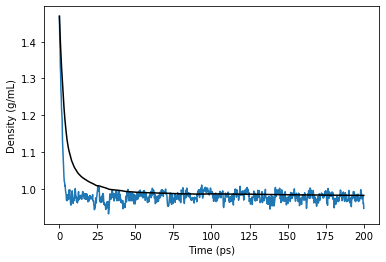

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv(f'scalars_{solvent_box_name}_N{number_of_solvent_molecules}.csv')
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
#obtain via cid??? search tool?
print("The experimental saturated liquid density of acetonitril at 298.15K: 0.95 g/ml")
print(f"The average density at convergion is: {ma_data[-1]}")
print(f"The absolute difference between obtained and experimental density is:{abs(ma_data[-1]-0.95)}")
plt.show()


##### Volume **V**

The average volume at convergion is: 12.375269212379248


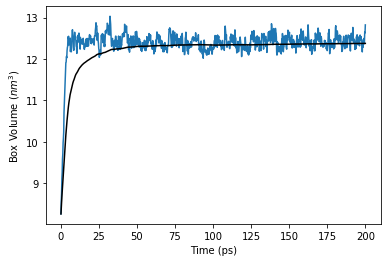

In [10]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
plt.show()

### Creating a box with solvated solute(s)

####  Determining the number of solvent molecules (upper bound)

At the moment this volume is calculated with some manual input extracted a coordinate file manipulated with the program of choice. Ideally, in the future, this is automated. Here the calculated number of molecules is an upper bound as we do not account for the volume of the solutes itselves. This is easily done with Gaussian using the Volume keyword.

In [68]:
from molmod.units import *
from molmod.constants import *
import numpy as np

rho_exp = 0.950*gram/(centimeter**3)
MM= 73*gram #Molecular weight

##Determine initial box dimensions
#The number of solvent layers, can be determined using rdfs, or just use one in case only short range interactions are important and no proton-hopping mechanisms occur
number_of_solvent_layers = 1
Length_solutes =[6.3,7.0,5.5]
Length_solvent =[4.3]
Margin = [2.0] #this could be interesting to allow for through-space interactions occuring with the solvent which prevent close proximities
#2 options, on one hand you can allow for all solutes to be able to diffuse away from each other and get surrounded
# by a number of solvent layers (option 1); secondly one can make sure the total complex is surrounded with n solvent layers
# this latter option (option2) allows one to prevent far diffusion of the solutes and hence model reactivity?

option = 2

#If the solvent is a mixture one could calculate an alternative length? or take max length ?

Max_length = 0

if option==1:
    for length in Length_solutes:
        Max_length += number_of_solvent_layers*2*(Length_solvent[0]+Margin[0]) + length  
elif option==2:
    Max_length += number_of_solvent_layers*(Length_solvent[0]+Margin[0])*2 + sum(Length_solutes)
Total_length = np.sqrt((Max_length**2)/3)

Volume = (Total_length*angstrom)**3   #in bohr³
#Determine the number of solvent molecules
#1L ~= 1dm³ , approx
n_solvent_mol = int((rho_exp * Volume / MM) *avogadro)
print(f'The number of solvent molecules is:{n_solvent_mol}')


The number of solvent molecules is:46


#### Set box settings

In [69]:
#settings for solvent box
sb_name = f'dbu_thiol_aCC_{len(solutes)}solutes_N{n_solvent_mol}solvent_box'
box_size = Total_length

#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [1,1,1,n_solvent_mol]
if len(n_molecules)!= len(solutes)+len(solvents): raise ValueError('Ascribe a number of molecules for each species') 

### Using the SolvationToolkit package to solvate the system (https://github.com/MobleyLab/SolvationToolkit); https://github.com/openforcefield/open-forcefield-tools; 

The use of some of the features included in this package require an OpenEye licence which can be requested from their site. Adviced in case you want make use of this the open Eye package more frequently. Open Eye provides a very broad scope of tools to handle molecular objects for simulation purposes. Alternatively to OpenEye we use openmoltools (*Vide infra*)

In [ ]:
'''from solvationtoolkit.solvated_mixtures import *
#specify the path to save the data and setup system
sb_name = 'dbu_dmf'
solvent_box = MixtureSystem(f"./{sb_name}")

solvent_box.addComponent(label='dmf',smiles='CN(C)C=O',number=100)
solvent_box.addComponent(label='dbu',smiles='C1CCC2=NCCCN2CC1',number='1')
mixture.build()
'''

###  Using openmoltools (https://github.com/choderalab/openmoltools)

I have manually adjusted the packmol.py file (in ~/anaconda3/envs/openmm/lib/python3.7/site-packages/openmoltools) as the bonds were defined as an array of 1 x 4 
but in this case the bond type and order should be in the 3rd and fourth column, this is however not the case.
there for this is put to zero at the end which corresponds to a bond order and type of None, though antechambers
will put this correct normally based on the bonds. Alternatively n_atoms is added after each molecule 
to bonds_i [0] and [1] instead to avoid a potential loss of information.
'''
    #cast atom type and order to 0
    if len(bonds[0])==4:
        for idx,frame in enumerate(bonds):
               bonds[idx][2] = 0
               bonds[idx][3] = 0

TODO: Report to openmoltools

In [70]:
from openmoltools import packmol
import mdtraj as md

pdb_filenames = [f"CID_{cid}.pdb" for cid in solutes+solvents]

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{sb_name}_openmoltools.pdb')



# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmp_gwurym_/tmp5u9o3ky0.pdb
add_amber_ter


structure CID_81184.pdb
  number 1 
  inside box 0. 0. 0. 16.128798 16.128798 16.128798
end structure

structure CID_78175.pdb
  number 1 
  inside box 0. 0. 0. 16.128798 16.128798 16.128798
end structure

structure CID_7509.pdb
  number 1 
  inside box 0. 0. 0. 16.128798 16.128798 16.128798
end structure

structure CID_6228.pdb
  number 46 
  inside box 0. 0. 0. 16.128798 16.128798 16.128798
end structure

<mdtraj.Topology with 49 chains, 49 residues, 612 atoms, 567 bonds>


### Visualize the created solvent box

In [71]:
import nglview
import ipywidgets

nglview.show_file(f"{sb_name}_openmoltools.pdb")

NGLWidget()

##  Generate a forcefield for the solvent box

In [75]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"CID_{cid}.sdf" for cid in solutes+solvents]
pdb_box = PDBFile(f"{sb_name}_openmoltools.pdb")
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
box_positions = pdb_box.getPositions()
off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
#if Total_length/2*angstrom > 1*nanometer:
off_box_system = off_forcefield.create_openmm_system(off_box_topology)
#off_box_system.setNonbondedMethod(PME)
#else:
    #off_box_system.setCutoffDistance(Total_length/2*angstrom)
    #off_box_system = off_forcefield.create_openmm_system(off_box_topology,nonbondedMethod=PME,nonbondedCutoff=Total_length/2*angstrom)
    #off_box_system.setNonbondedMethod(PME)



## Performing an energy calculations

In [78]:
import numpy as np

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(off_box_system, integrator)
context.setPositions(box_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)


print(f"Original energy: {energy}")

Original energy: 5827.064907281102 kJ/mol


## Performing a molecular dynamics simulations for the new compound

In [79]:
from sys import stdout
import time

#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open(f"initial_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True,volume=True, density=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")


Starting simulation
#"Step","Temperature (K)","Box Volume (nm^3)","Density (g/mL)","Elapsed Time (s)"
10000,303.4877145245693,6.300735137595172,0.9927540771790018,0.00013184547424316406
20000,291.29911280436244,6.225954260474582,1.0046781963662874,14.732744693756104
30000,295.82011722207943,6.348605922163776,0.9852683524166053,29.419393301010132
40000,281.68344763064835,6.552684928702497,0.9545828259914795,46.42143750190735
50000,311.95672631488236,6.328719339715168,0.9883643374449472,62.50310826301575
60000,267.79996866407873,6.253217310333622,1.0002979564992736,79.00913071632385
70000,296.6030731280871,6.16758705573086,1.014186008328889,94.83570599555969
80000,294.39961895894817,6.239437192717616,1.0025071659304863,111.07788920402527
90000,282.3592422662915,6.430700607873667,0.9726903612048066,127.49151492118835
100000,294.39935653442876,6.486081000906058,0.9643851959602134,142.91147255897522
110000,301.64074283597466,6.279633913037811,0.9960899924573267,158.45599246025085
120000,305

## Visualize the output

In [80]:
traj = md.load(f'traj_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', top=f"initial_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb")
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=10000)

## Post-Processing

The average density at convergion is: 0.9872056087705586


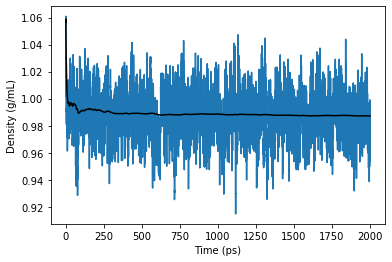

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv")
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

The average volume at convergion is: 6.33814424689969
The box dimensions for a NVT simulation should hence be: 18.50634722250063


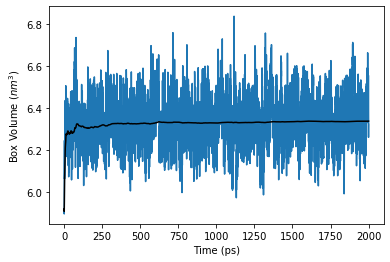

In [87]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()